# PIP examples

In this notebook we will show how to compute power spectra with PIP weights, with major inspiration from https://arxiv.org/pdf/1703.02070.pdf. The power spectrum estimator with PIP correction is introduced in https://arxiv.org/pdf/1912.08803.pdf.
Look first at notebook basic_examples.ipynb to understand the *pypower* API. One can also look at the notebook https://github.com/cosmodesi/pycorr/blob/main/nb/pip_examples.ipynb for similar examples for the correlation function. 

In [1]:
import os
import tempfile

import numpy as np
from scipy import spatial
from matplotlib import pyplot as plt

from pypower import CatalogFFTPower, utils, setup_logging
# To install pycorr: pip install git+https://github.com/adematti/pycorr#egg=pycorr[corrfunc]
from pycorr import TwoPointCorrelationFunction

# To activate logging
setup_logging()

In [2]:
# First, generate fake data with cartesian positions and weights, in a box of size 800 (Mpc/h) at 1000 (Mpc/h).

def generate_catalogs(size=100000, boxsize=(800,)*3, offset=(1000.,0,0), n_individual_weights=1, seed=42):
    rng = np.random.RandomState(seed=seed)
    positions = [o + rng.uniform(-0.5, 0.5, size)*b for o, b in zip(offset, boxsize)]
    weights = [np.ones(size, dtype='f8') for i in range(n_individual_weights)]
    return positions, weights

size = 200000
parent_positions, parent_weights = generate_catalogs(size=size, seed=43)
randoms_positions, randoms_weights = generate_catalogs(size=10*size, seed=84)

# Three scenarii
- uncorrelated: objects within close pairs are randomly removed. That an object in close pair does not receive a fiber does not impact on the fiber assignment for the other object: selection probabilities of close objects are uncorrelated. There are no zero probability pairs.
- onepass: we randomly pick a close pair and randomly discard one of the two objects; we iterate the procedure until there are no more close pairs. This is the "maximum randomness" algorithm used in https://arxiv.org/pdf/1703.02070.pdf. Selection probabilites of close objects are correlated. There are zero probability pairs.
- twopass: same as singlepass, with an extra pass on objects left without fiber in the first pass. All pairs are non-zero probability with multiple passes.
- twopass-fsky: same as singlepass, with an extra pass on objects left without fiber in the first pass on some fraction of the sky. All pairs are non-zero probability in the region with multiple passes.

In [3]:
# First find all (unique) pairs within 0.08 deg.
def find_collision_pairs(positions, radius_in_degree=0.08):
    distance = sum(p**2 for p in positions)**0.5
    unit_positions = np.array([p/distance for p in positions]).T
    tree = spatial.cKDTree(unit_positions, leafsize=16, compact_nodes=True, copy_data=False, balanced_tree=True)
    radius = 2.*np.sin(np.radians(radius_in_degree) / 2.) # distance on the unit sphere
    pairs = tree.query_pairs(radius, p=2., eps=0, output_type='ndarray')
    return pairs

parent_size = len(parent_positions[0])
target_pairs = find_collision_pairs(parent_positions)
print('Found {:d}/{:d} targets in pairs.'.format(target_pairs.shape[0], parent_size))

Found 170133/200000 targets in pairs.


In [4]:
def run_uncorrelated_fiber_assignment(size, target_pairs, prob=0.5, nrealizations=65, seed=42):
    # Objects within close pairs are randomly removed with probability prob.
    bits = []
    indices_close_pairs = np.unique(target_pairs)
    rng = np.random.RandomState(seed=seed)
    for ireal in range(nrealizations):
        #print(ireal, end=" ")
        bit = np.ones(size, dtype='?')
        bit[indices_close_pairs] = rng.uniform(0., 1., indices_close_pairs.size) < prob
        bits.append(bit)
    return bits


def mr_fiber_collisions(rng, size, pairs, groupids):
    # We randomly pick a close pair and randomly discard one of the two objects.
    # We iterate the procedure until there are no more close pairs.
    bit = np.ones(size, dtype='?')
    collision_groups_pairs = {}

    for pair in pairs:
        groupid = groupids[pair[0]]
        assert groupid == groupids[pair[1]]
        if groupid not in collision_groups_pairs:
            collision_groups_pairs[groupid] = []
        collision_groups_pairs[groupid].append(pair)
    
    while len(collision_groups_pairs):
        for igrp, grp in list(collision_groups_pairs.items()):
            index = grp[rng.randint(len(grp))][rng.randint(2)]
            bit[index] = 0
            grp = [pair for pair in grp if index not in pair]
            if not grp:
                del collision_groups_pairs[igrp]
            else:
                collision_groups_pairs[igrp] = grp

    return bit


def find_collision_groups(size, pairs):
    # Group pairs into collision groups
    collision_groups = []
    groupids = -np.ones(size, dtype='i4')
    for pair in pairs:
        groupid1, groupid2 = groupids[pair[0]], groupids[pair[1]]
        if groupid1 < 0 and groupid2 < 0:
            groupids[pair[0]] = groupids[pair[1]] = len(collision_groups)
            collision_groups.append(set(pair))
        elif groupid1 >= 0 and groupid2 < 0:
            groupids[pair[1]] = groupid1
            collision_groups[groupid1].add(pair[1])
        elif groupid2 >= 0 and groupid1 < 0:
            groupids[pair[0]] = groupid2
            collision_groups[groupid2].add(pair[0])
        elif groupid1 != groupid2:
            for idx in collision_groups[groupid2]:
                groupids[idx] = groupid1
            collision_groups[groupid1] |= collision_groups[groupid2]
            collision_groups[groupid2] = set() # to keep groupids the same
    return groupids


def _run_mr_fiber_assignment(ireal, size=None, pairs=None, groupids=None, npasses=1, indices_multiple_pass=None, seed=42):
    rng = np.random.RandomState(seed=seed+ireal)
    bit = np.zeros(size, dtype='?')
    n_pairs = pairs.shape[0] + 1
    for ipass in range(npasses):
        if ipass == 0:
            indices = np.arange(size)
        else:
            indices = indices_multiple_pass
        collided = np.flatnonzero(~bit[indices])
        _pairs = pairs[np.all(np.isin(pairs, collided), axis=-1)]
        _n_pairs = _pairs.shape[0]
        assert _n_pairs < n_pairs
        n_pairs = _n_pairs
        bit[indices] = mr_fiber_collisions(rng, size, _pairs, groupids)[indices]
    return bit


def run_mr_fiber_assignment(size, pairs, npasses=1, fsky_multiple_pass=1., nrealizations=65, seed=42):
    # Run mr_fiber_collisions with multiple passes.
    # The first pass is run full-sky, the other passes are run on fsky_multiple_pass of the sky.
    indices_multiple_pass = np.arange(int(fsky_multiple_pass * size + 0.5))
    bits = []
    groupids = find_collision_groups(size, pairs)
    
    from multiprocessing import Pool
    from functools import partial
    with Pool(4) as pool:
        bits = pool.map(partial(_run_mr_fiber_assignment, size=size, pairs=pairs, groupids=groupids,
                                npasses=npasses, indices_multiple_pass=indices_multiple_pass, seed=seed), range(nrealizations))
    return bits

# getting fiber assignment runs
nrealizations = 65
cases = {}

cases['uncorrelated'] = {'bits': run_uncorrelated_fiber_assignment(parent_size, target_pairs, nrealizations=nrealizations, prob=0.5, seed=42)}
cases['onepass'] = {'bits': run_mr_fiber_assignment(parent_size, target_pairs, nrealizations=nrealizations, npasses=1, fsky_multiple_pass=1., seed=42)}
cases['twopass'] = {'bits': run_mr_fiber_assignment(parent_size, target_pairs, nrealizations=nrealizations, npasses=2, fsky_multiple_pass=1., seed=42)}
cases['twopass-fsky'] = {'bits': run_mr_fiber_assignment(parent_size, target_pairs, nrealizations=nrealizations, npasses=2, fsky_multiple_pass=0.5, seed=42)}

for name, case in cases.items():
    this = case['bits'][0]
    fiberassign_bits = utils.pack_bitarrays(*case['bits'][1:], dtype=np.uint64)
    # restricting to the objects that received a fiber in the actual pass
    positions = [p[this] for p in parent_positions]
    weights = [w[this] for w in parent_weights]
    bitwise_weights = [w[this] for w in fiberassign_bits]
    case.update(positions=positions, weights=weights, bitwise_weights=bitwise_weights)

In [5]:
# Routine to run power spectrum estimations with different weighting schemes
def run_case(case, edges, ells=(0, 2, 4), boxsize=1000., nmesh=200, resampler='tsc', interlacing=2, direct_limits=(0., 0.3), nthreads=4):
    positions = case['positions']
    weights = case['weights']
    bitwise_weights = case['bitwise_weights']

    # Parent sample
    result_parent = CatalogFFTPower(data_positions1=parent_positions, data_weights1=parent_weights,
                                    randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                                    boxsize=boxsize, nmesh=nmesh, resampler=resampler, interlacing=interlacing,
                                    edges=edges, ells=ells, direct_limits=direct_limits, position_type='xyz', mpiroot=0).poles

    # No weights
    result_fibered = CatalogFFTPower(data_positions1=positions, data_weights1=weights,
                                    randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                                    boxsize=boxsize, nmesh=nmesh, resampler=resampler, interlacing=interlacing,
                                    edges=edges, ells=ells, direct_limits=direct_limits, position_type='xyz', mpiroot=0).poles
    
    
    # With iip weights (nrealizations already includes current realization)
    wiip = nrealizations/(1 + utils.popcount(*bitwise_weights))
    result_iip = CatalogFFTPower(data_positions1=positions, data_weights1=wiip*weights[0],
                                 randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                                 boxsize=boxsize, nmesh=nmesh, resampler=resampler, interlacing=interlacing,
                                 edges=edges, ells=ells, direct_limits=direct_limits, position_type='xyz', mpiroot=0).poles

    # With pip weights
    result_pip = CatalogFFTPower(data_positions1=positions, data_weights1=bitwise_weights + weights,
                                 randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                                 boxsize=boxsize, nmesh=nmesh, resampler=resampler, interlacing=interlacing,
                                 edges=edges, ells=ells, direct_limits=direct_limits, position_type='xyz', mpiroot=0).poles

    # With pip + angular weights
    # We provide the parent sample as randoms, and switch to "weight" estimator
    # First D1_parentD2_parent/D1D2_PIP
    wangedges = np.logspace(-3, 0., 31)
    wangD1D2 = TwoPointCorrelationFunction('theta', wangedges, data_positions1=positions, data_weights1=bitwise_weights + weights,
                                           randoms_positions1=parent_positions, randoms_weights1=parent_weights,
                                           estimator='weight', engine='corrfunc', position_type='xyz', output_sepavg=False, nthreads=nthreads)

    # First D1_parentR2/D1R2_IIP
    # Note that input bitwise weights are automatically turned into IIP when other weight is float
    wangD1R2 = TwoPointCorrelationFunction('theta', wangedges, data_positions1=positions, data_weights1=bitwise_weights + weights,
                                           data_positions2=randoms_positions, data_weights2=randoms_weights,
                                           randoms_positions1=parent_positions, randoms_weights1=parent_weights,
                                           randoms_positions2=randoms_positions, randoms_weights2=randoms_weights,
                                           estimator='weight', engine='corrfunc', position_type='xyz', output_sepavg=False, nthreads=nthreads)
    
    # PIP weights + angular upweights D1D2_twopoint_weights and D1R2_twopoint_weights
    result_pipang = CatalogFFTPower(data_positions1=positions, data_weights1=bitwise_weights + weights,
                                    randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                                    D1D2_twopoint_weights=wangD1D2, D1R2_twopoint_weights=wangD1R2,
                                    boxsize=boxsize, nmesh=nmesh, resampler=resampler, interlacing=interlacing,
                                    edges=edges, ells=ells, direct_limits=direct_limits, position_type='xyz', mpiroot=0).poles

    return result_parent, result_fibered, result_iip, result_pip, result_pipang

[000000.49]  02-18 09:56  CatalogFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[200 200 200], boxsize=[1000. 1000. 1000.], boxcenter=[ 9.99999846e+02 -8.54187298e-05  8.72778854e-05], dtype=float64).
[000002.10]  02-18 09:56  CatalogMesh                  INFO     Running interlacing at order 2.
[000004.36]  02-18 09:56  CatalogFFTPower              INFO     Done painting catalog 1 to mesh.
[000004.36]  02-18 09:56  CatalogFFTPower              INFO     Using 19 k-bins between 0.100 and 0.480.
[000005.91]  02-18 09:56  CatalogFFTPower              INFO     Running power spectrum estimation.
[000006.85]  02-18 09:56  CatalogFFTPower              INFO     ell = 0 done; 1 r2c completed
[000007.24]  02-18 09:56  numexpr.utils                INFO     NumExpr defaulting to 4 threads.
[000008.79]  02-18 09:56  CatalogFFTPower              INFO     ell = 2 done; 5 r2c completed
[000009.44]  02-18 09:56  CatalogFFTPower              INFO     Power spectrum computed 

[000211.62]  02-18 10:00  CatalogFFTPower              INFO     Power spectrum computed in elapsed time 5.39 s.
[000212.29]  02-18 10:00  CatalogFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[200 200 200], boxsize=[1000. 1000. 1000.], boxcenter=[ 9.99999846e+02 -8.54187298e-05  8.72778854e-05], dtype=float64).
[000214.66]  02-18 10:00  CatalogMesh                  INFO     Running interlacing at order 2.
[000218.14]  02-18 10:00  CatalogFFTPower              INFO     Done painting catalog 1 to mesh.
[000218.14]  02-18 10:00  CatalogFFTPower              INFO     Using 19 k-bins between 0.100 and 0.480.
[000220.30]  02-18 10:00  CatalogFFTPower              INFO     Running power spectrum estimation.
[000221.92]  02-18 10:00  CatalogFFTPower              INFO     ell = 0 done; 1 r2c completed
[000224.84]  02-18 10:00  CatalogFFTPower              INFO     ell = 2 done; 5 r2c completed
[000225.98]  02-18 10:00  CatalogFFTPower              INFO     Power spe

[000464.87]  02-18 10:04  CatalogFFTPower              INFO     Power spectrum computed in elapsed time 4.92 s.
[000477.06]  02-18 10:04  KDTreeDirectPowerEngine      INFO     Building tree took 2.08 s.
[000477.06]  02-18 10:04  KDTreeDirectPowerEngine      INFO     Sum over pairs took 10.05 s.
[000477.06]  02-18 10:04  KDTreeDirectPowerEngine      INFO     Direct power computed in elapsed time 12.17 s.
[000477.07]  02-18 10:04  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.WeightTwoPointEstimator'>.
[000477.07]  02-18 10:04  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000478.39]  02-18 10:04  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.
[000479.65]  02-18 10:04  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.WeightTwoPointEstimator'>.
[000479.65]  02-18 10:04  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000479.98]  02-18 1

[000804.63]  02-18 10:10  CatalogFFTPower              INFO     ell = 0 done; 1 r2c completed
[000807.13]  02-18 10:10  CatalogFFTPower              INFO     ell = 2 done; 5 r2c completed
[000808.11]  02-18 10:10  CatalogFFTPower              INFO     Power spectrum computed in elapsed time 4.96 s.
[000816.01]  02-18 10:10  KDTreeDirectPowerEngine      INFO     Building tree took 1.10 s.
[000816.01]  02-18 10:10  KDTreeDirectPowerEngine      INFO     Sum over pairs took 6.76 s.
[000816.01]  02-18 10:10  KDTreeDirectPowerEngine      INFO     Direct power computed in elapsed time 7.88 s.
[000816.06]  02-18 10:10  KDTreeDirectPowerEngine      INFO     Setting IIP weights for first catalog.
[000936.83]  02-18 10:12  KDTreeDirectPowerEngine      INFO     Building tree took 19.57 s.
[000936.83]  02-18 10:12  KDTreeDirectPowerEngine      INFO     Sum over pairs took 100.91 s.
[000936.83]  02-18 10:12  KDTreeDirectPowerEngine      INFO     Direct power computed in elapsed time 120.77 s.


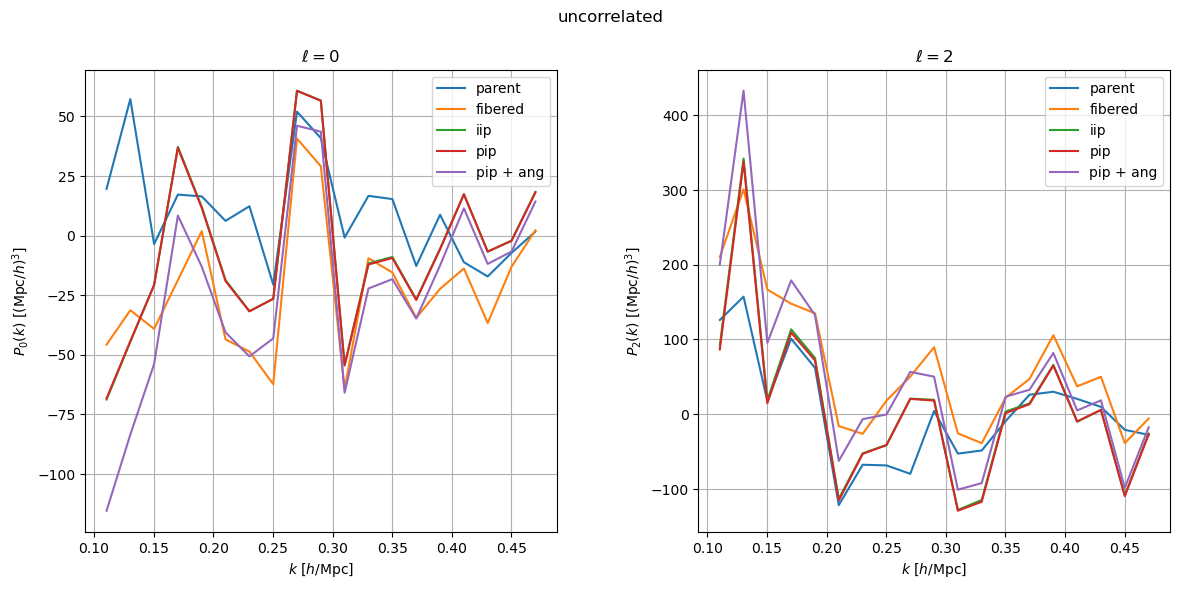

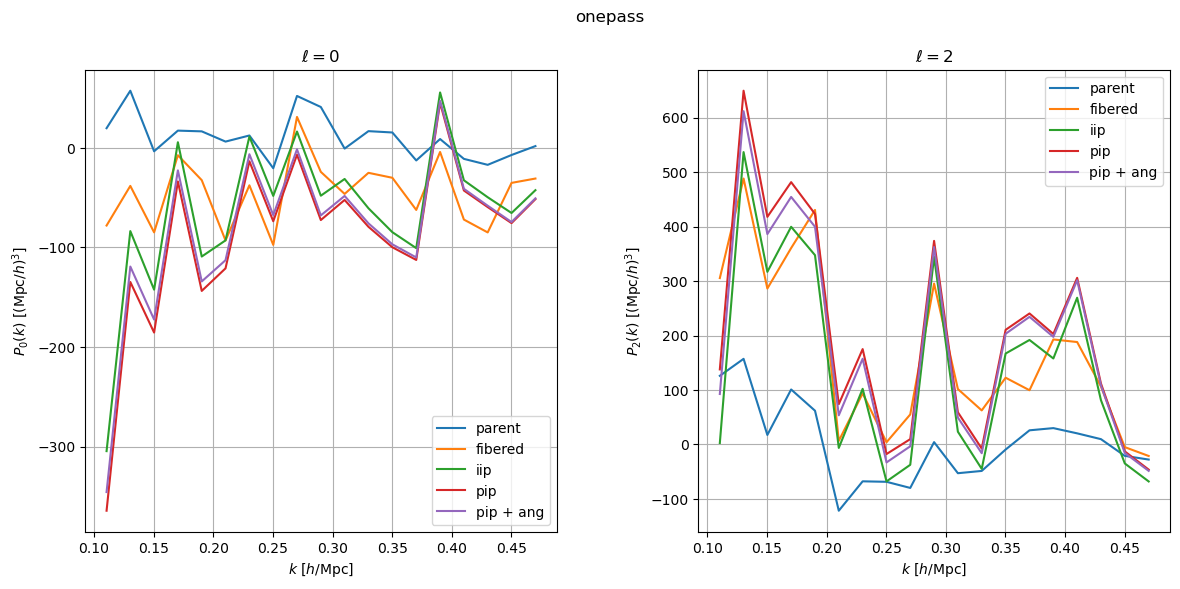

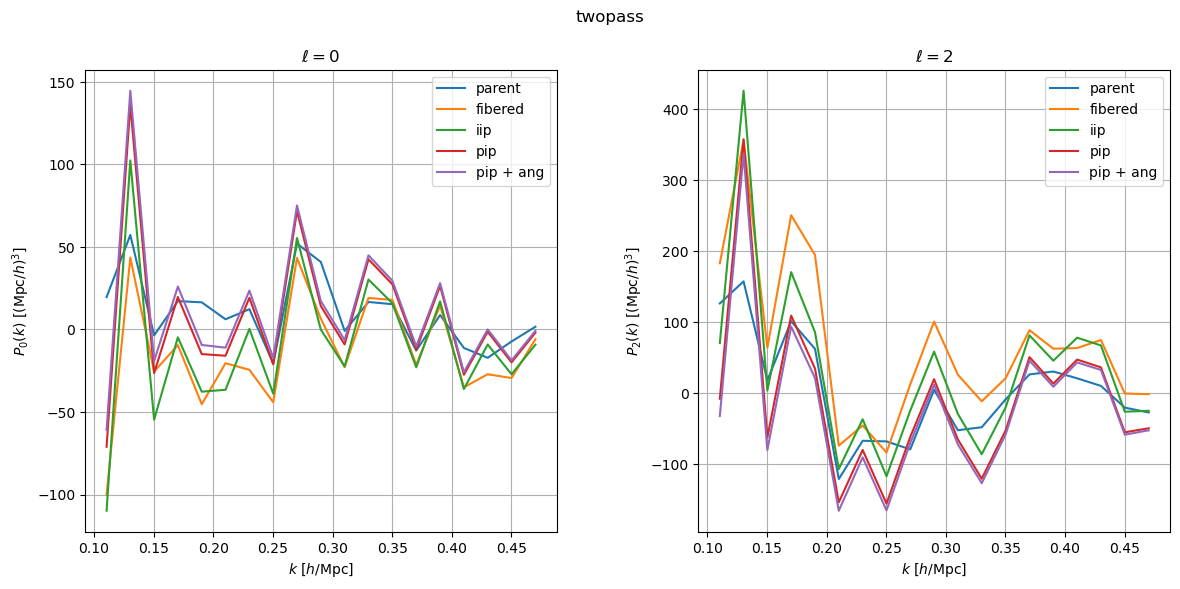

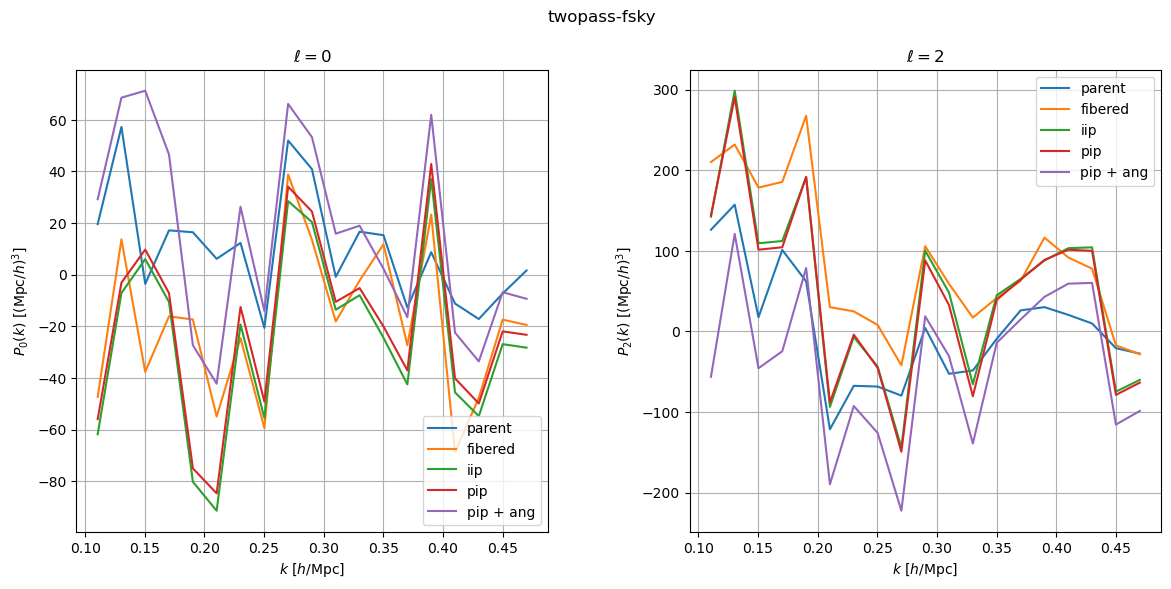

In [6]:
ells = (0, 2)
edges = np.arange(0.1, 0.5, 0.02)

# Deactivate logging as it is a bit wordy
setup_logging('info')
for name in cases:
    
    result_parent, result_fibered, result_iip, result_pip, result_pipang = run_case(cases[name], edges, ells=ells)
    fig, lax = plt.subplots(ncols=len(result_parent.ells), nrows=1, sharex=False, sharey=False, figsize=(14, 6))
    fig.suptitle(name)
    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    lax = lax.flatten()
    for ax, ell in zip(lax, result_parent.ells):
        ax.set_title(r'$\ell = {}$'.format(ell))
        ax.plot(*result_parent(ell=ell, return_k=True, complex=False), label='parent')
        ax.plot(*result_fibered(ell=ell, return_k=True, complex=False), label='fibered')
        ax.plot(*result_iip(ell=ell, return_k=True, complex=False), label='iip')
        ax.plot(*result_pip(ell=ell, return_k=True, complex=False), label='pip')
        ax.plot(*result_pipang(ell=ell, return_k=True, complex=False), label='pip + ang')
        ax.set_xlabel('$k$ [$h/\mathrm{Mpc}$]')
        ax.set_ylabel(r'$P_{:d}(k)$ [$(\mathrm{{Mpc}}/h)^{{3}}$]'.format(ell))
        ax.grid(True)
        ax.legend()

plt.show()

### The different curves
- The "parent" curve corresponds to the power spectrum multipoles of the initial target or "unfibered" sample. This curve is zero as input positions are uniformly random.
- The "fibered" curve corresponds to the power spectrum multipoles of the "fibered" sample, i.e. the sample of objects that received a fiber.
- The "iip" curve corresponds to the power spectrum multipoles of the fibered sample with individual inverse weights defined by wiip = nrealizations/(1 + popcount(bitwise_weight)), which ignores correlation in selection probabilites of close objects ("popcount" counts the number of 1 bits, i.e. returns the number of fiber assignment realizations where this object was selected).
- The "pip" curve corresponds to the the power spectrum multipoles of the fibered sample with pairwise inverse probability pairs defined for a *pair* of objects by wpip_ij = nrealisations/(1 + popcount(bitwise_weight_i & bitwise_weight_j)) (here "popcount" counts the number of fiber assignment realizations where this *pair* was selected). In practice, the power spectrum estimation is split as the sum of the power spectrum multipoles estimated with wiip on a mesh, and the contribution wpip_ij - wiip_i * wiip_j, which contributes only below the selection-correlation length, is computed via direct summation.
- The "pip + ang" curve is similar as "pip", but with direct power spectrum computation including additional angular weights for D1D2 and D1R2 pairs, defined as: wangD1D2 = D1_parentD2_parent/D1D2_PIP and wangD1R2 = D1_parentR2/D1R2_IIP. The weights correct for zero-probability close pairs, assuming that non-zero probability pairs are representative of the zero-probability ones.

### The different plots (cases)
- In the "uncorrelated" case, selection probabilities of close objects are uncorrelated. Hence the power spectrum is fully corrected by IIP weights. PIP weights are statistically equivalent to IIP weights in this case.
- In the "onepass" case, selection probabilities of close objects are correlated. Hence PIP weights are required. Yet we see no weighting scheme can recover an unbiased estimate of the power spectrum. This is because all pairs are zero-probability: what we want to avoid in a real survey.
- In the "twopass" case, fiber assignment is run twice. Hence there are no zero-probability pairs. We see that PIP weights are required (IIP weights are not sufficient), because selection probabilities of close objects are correlated.
- In the "twopass-fsky" case, fiber assignment is twice only one 50% of the footprint. There are zero-probability pairs, hence the angular upweights are required.